   # Final Project


In [10]:
import mdptoolbox
import mdptoolbox.example
import numpy as np
import scipy.constants as sc
import itertools
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import animation
from abc import ABC, abstractmethod


   ## Radar Environment


   The radar environment is defined by a set of possible postion states
   $\mathcal{P}$ and a set of velocity states $\mathcal{V}$.

   $\mathcal{P} = \{\mathbf{r_1}, \mathbf{r_2}, \dots, \mathbf{r_\rho}\}$

   $\mathcal{V} = \{\mathbf{v_1}, \mathbf{v_2}, \dots, \mathbf{v_\nu}\}$

   where $\rho$ is the number of possible position states and $\nu$ is the number
   of possible velocities.

   Each $\mathbf{r_i}, \mathbf{v_i}$ are 3-dimensional row vectors

   $\mathbf{r_i} = \left[r_x, r_y, r_z \right]$

   $\mathbf{v_i} = \left[v_x, v_y, v_z \right]$

   where x, y and z represent the cross-range, down-range, and vertical dimensions,
   respectively.


   For this simple script, only 1D range and velocity will be considered.


   ## Simulation Objects


In [11]:


class Radar:
    """Monostatic radar object"""

    def __init__(self, position=np.zeros((3,)), prf=1e3, center_freq=10e9,
                 tx_gain=100, tx_power=100, samp_rate=1e6, num_pulse_cpi=128, noise_fig=5, T0=270):
        self.position = np.array(position)
        self.prf = prf
        self.center_freq = center_freq
        self.tx_gain = tx_gain
        self.noise_fig = noise_fig
        self.T0 = T0
        # Assume monostatic
        self.rx_gain = tx_gain
        self.tx_power = tx_power
        self.samp_rate = samp_rate
        self.num_pulse_cpi = num_pulse_cpi
        # Derived parameters
        self.lambda0 = sc.c / center_freq
        self.max_range = sc.c/(2*prf)
        self.max_doppler = prf/2

        self.action = np.array([])

    def rx_power(self, target):
        R = np.linalg.norm(target.position - self.position)
        Pr = self.tx_power*self.tx_gain*self.rx_gain*self.lambda0**2 * \
            target.rcs/((4*sc.pi)**3*R**4)
        return Pr

    def SINR(self, target, interference, wave):
        noise_power = sc.k*self.T0*self.samp_rate*self.noise_fig
        # Interference power only contributes to SINR if it is in the same
        # frequency band
        if sum(self.action*interference.current_state) > 0:
            interference_power = interference.tx_power
        else:
            interference_power = 0
        sinr = self.rx_power(target) / (noise_power + interference_power)
        # SINR after pulse compression and coherent integration
        sinr *= self.num_pulse_cpi * (wave.pulsewidth*wave.bandwidth)
        sinr = 10*np.log10(sinr)

        return sinr


class Waveform:
    """Linear FM Waveform object"""

    def __init__(self, bandwidth, pulsewidth):
        self.bandwidth = bandwidth
        self.pulsewidth = pulsewidth


class Target:
    """Point target object"""

    def __init__(self, position, velocity, rcs):
        """Instantiate a target object

        Args:
            position (ndarray): A vector of the XYZ position of the target in an
            arbitrary coordinate system
            velocity (ndarray): A vector of the XYZ velocity of the target in an
            arbitrary coordinate system
            rcs (float): The radar cross section of the target (m^2) 
        """
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        self.rcs = rcs

    def step(self, dt):
        """Update the target motion profile

        Args:
            dt (float): Time change since last step
        """
        self.position += self.velocity*dt


class Interference(ABC):
    """Interference object base class"""

    def __init__(self, tx_power, states, state_ind):
        """Instantiate a new interference object

        Args:
            tx_power (float): Transmit power of the interference AT THE RADAR RECEIVER.
            Therefore, this is a very small value.
            TODO: Make this the actual transmitted power, then use scenario
            geometry to compute the power at the radar receiver. 

            states (_type_, optional): A matrix of all possible transmission
            frequencies in a discretized spectrum, where each row is a possible
            state. 
            Defaults to np.array([]).

            state_ind (int, optional): The row index of the current state in the
            states matrix.
            Defaults to 0.
        """
        self.tx_power = tx_power
        self.states = states
        self.state_ind = state_ind
        self.current_state = states[state_ind]

    @abstractmethod
    def step(self):
        """ 
        Define the frequency hopping behavior of the interference at each time step
        """
        pass


class ConstantInterference(Interference):
    """Constant interference object.

    This interferer transmits at a single frequency pattern for the entire simulation

    Args:
        Interference: Abstract interference parent class
    """

    def __init__(self, tx_power=0, states=np.array([]), state_ind=0):
        super(ConstantInterference, self).__init__(tx_power, states, state_ind)

    def step(self):
        """
        Continue transmitting at the same frequency
        """
        pass

# class PulsedInterference:
#     """
#     Interference that turns on and off every iteration, but stays in the same
#     frequency band
#     """

#     def __init__(self, inr=14, states=np.array([]), state_ind=0):
#         # ConstantInterference-to-noise ratio at the radar receiver. To simplify the
#         # scenario, this is position-independent
#         self.inr = inr
#         self.states = states
#         self.state_ind = state_ind
#         self.state = states[state_ind]

#     def step(self):
#         if np.sum(self.state) == 0:
#             self.state = self.states[self.state_ind]
#         else:
#             self.state = self.states[0]



   ### Interference Environment


In [12]:
N = 5
channel_bw = 100e6
subband_bw = channel_bw / N
channel = np.zeros((N,))
# Matrix of all unique interference states, where each row is a unique state and
# each column is a frequency bin
Theta = np.array(list(itertools.product([0, 1], repeat=N)))
# Interfering system
interference_state = 1
comms = ConstantInterference(
    tx_power=4.6e-13, states=Theta, state_ind=interference_state)



   ## Simulation Environment

   ### Radar and Target Parameters

In [13]:
# Radar system
radar = Radar(position=np.array(0), prf=2000,
              center_freq=10e9, tx_gain=100, tx_power=1e3, num_pulse_cpi=20)
# Transmitted waveform (linear FM)
wave = Waveform(bandwidth=20e6, pulsewidth=10e-6)
# Possible actions (assume transmission over contiguous sub-bands)
actions = np.zeros((0, N))
for i in range(N):
    state = np.zeros((N,))
    state[:i+1] = 1
    actions = np.append(actions, np.array([np.roll(state, j) for j in
                                           range(N-i)]), axis=0)
# Number of position states
rho = 10
# r = np.linspace(0, radar.max_range, rho)
r = np.linspace(0, 2e3, rho)
# Number of velocity states
nu = 10
v = np.linspace(-1/2, 1/2, nu) * (radar.prf*radar.lambda0/2)
target = Target(position=[], velocity=[], rcs=0.1)


   ### Reward structure


In [14]:
def reward(sinr, bw):
    r = 0
    # SINR reward structure
    if sinr < 0:
        r -= 35
    elif sinr >= 0 and sinr <= 2:
        r += 1
    elif sinr > 2 and sinr <= 5:
        r += 2
    elif sinr > 5 and sinr <= 8:
        r += 3
    elif sinr > 8 and sinr <= 11:
        r += 4
    elif sinr > 11 and sinr <= 14:
        r += 5
    elif sinr > 14 and sinr <= 17:
        r += 6
    elif sinr > 17 and sinr <= 20:
        r += 8
    else:
        r += 10

    # Bandwidth reward structure
    r += 10*(bw-1)
    return r


In [15]:


def animate_spectrum(tx, int):
    # tx: array of radar transmission actions, where each row is the spectrum
    # state for a test run
    # int: Array of interference states with the same shape as for the transmission
    A = actions.shape[0]

    def animate(i):
        action = tx[i, :]
        int_state = int[i, :]
        for ibin in range(len(radar_spectrum.patches)):
            # Get the histogram bin object
            bin = radar_spectrum.patches[ibin]
            int_bin = interference.patches[ibin]
            # Set the height of each bin
            bin.set_height(action[ibin])
            int_bin.set_height(int_state[ibin])
            # Set the color of each bin based on whether or not a collision exists
            if action[ibin] == int_state[ibin]:
                bin.set_color('r')
                int_bin.set_color('r')
            else:
                bin.set_color('b')
                int_bin.set_color('g')

        return radar_spectrum.patches

    fig, ax = plt.subplots()
    interference = plt.bar(range(N), np.ones(
        (N,)), width=1, edgecolor='k', color='g')
    radar_spectrum = plt.bar(
        range(N), np.ones((N,)), width=1, edgecolor='k', color='b')
    anim = animation.FuncAnimation(
        fig, animate, tx.shape[0], repeat=False, blit=True)
    # plt.show()
    anim.save('test.mp4')



   ## Train the MDP

In [16]:
# Number of possible states
# For this simulation, the set of possible states denotes all possible
# combinations of target position states, target velocity states, and
# interference states.
S = rho*nu*2**N
# Number of possible actions
A = actions.shape[0]
# Initialize the transition and reward matrices
# The first index is the action, the second is the initial state, and the third
# is the final state. The indexing for the states is position -> velocity ->
# interference-major. That is, for a given position, all velocities are
# enumerated before incrementing the position, and for a given velocity all
# interference states are enumerated. You can think of the position as the "most
# significant bit" and interference as the "least significant bit".
T = np.zeros((A, S, S))
R = np.zeros((A, S, S))

num_train = int(1e3)
num_test = int(1e2)
time = np.linspace(0, 1500, 50)
# Time step for the simulation
dt = time[1] - time[0]
for itrain in range(num_train):
    # Randomly select a starting position and target velocity
    target.position = np.random.choice(r)
    target.velocity = np.random.choice(v)
    # Add a gaussian perturbance to the position and velocity
    target.position += np.random.randn()
    target.velocity += np.random.randn()

    for t in time:
        # Calculate the initial state
        old_pos_state = np.digitize(target.position, r)-1
        old_vel_state = np.digitize(target.velocity, v)-1
        old_interference_state = comms.state_ind
        old_state = old_pos_state*nu * \
            (2**N) + old_vel_state*(2**N) + old_interference_state
        # Randomly select a valid action
        action_index = np.random.randint(0, A)
        radar.action = actions[action_index, :]
        # Determine the bandwidth used, then update the interference, position, range, and SINR
        wave.bandwidth = subband_bw*np.sum(radar.action)
        comms.step()
        target.step(dt)
        sinr = radar.SINR(target, comms, wave)
        # Determine the new state
        new_pos_state = np.digitize(target.position, r)-1
        new_vel_state = np.digitize(target.velocity, v)-1
        new_interference_state = comms.state_ind
        new_state = new_pos_state*nu * \
            (2**N) + new_vel_state*(2**N) + new_interference_state
        # Update the transition and reward matrices
        T[action_index, old_state, new_state] += 1
        R[action_index, old_state,
            new_state] += reward(sinr, np.sum(radar.action))
# Normalize the transition probability matrix to make it stochastic
T = np.array([normalize(T[a], axis=1, norm='l1') for a in range(A)])
# Also need to add a 1 to the diagonals of the matrices where the probability is zero
for a in range(A):
    ind = np.where(T[a].sum(axis=1) == 0)[0]
    for i in ind:
        T[a, i, i] = 1
        R[a, i, i] = 0

# Use policy iteration to determine the optimal policy
pi = mdptoolbox.mdp.PolicyIteration(T, R, 0.9)
pi.run()



 ## Test the MDP

In [17]:
current_reward = np.zeros((time.shape[0], num_test))
current_sinr = np.zeros((time.shape[0], num_test))
for itest in range(num_test):
    # Select a NEW trajectory that was not used for training
    # Randomly select a starting position and target velocity
    target.position = np.random.choice(r)
    target.velocity = np.random.choice(v)
    # Add a gaussian perturbance to the position and velocity
    target.position += np.random.randn()
    target.velocity += np.random.randn()
    tx_history = np.empty((0, N))
    interference_history = np.zeros((0, N))
    for itime in range(time.shape[0]):
        # Calculate the initial state
        old_pos_state = np.digitize(target.position, r)-1
        old_vel_state = np.digitize(target.velocity, v)-1
        old_interference_state = comms.state_ind
        old_state = old_pos_state*nu * \
            (2**N) + old_vel_state*(2**N) + old_interference_state
        # Select an action from the policy
        radar.action = actions[pi.policy[old_state], :]
        tx_history = np.append(tx_history, np.reshape(
            radar.action, (1, N)), axis=0)
        # Save the scenario for visualization
        interference_history = np.append(interference_history, np.reshape(
            comms.current_state, (1, N)), axis=0)

        # Determine the bandwidth used, then update the interference, position, range, and SINR
        wave.bandwidth = subband_bw*np.sum(radar.action)
        comms.step()
        target.step(dt)
        sinr = radar.SINR(target, comms, wave)
        current_sinr[itime, itest] = sinr
        if itime > 0:
            current_reward[itime, itest] = current_reward[itime -
                                                          1, itest] + reward(sinr, np.sum(radar.action))
        # Determine the new state
        new_pos_state = np.digitize(target.position, r)-1
        new_vel_state = np.digitize(target.velocity, v)-1
        new_interference_state = comms.state_ind
        new_state = new_pos_state*nu * \
            (2**N) + new_vel_state*(2**N) + new_interference_state
current_reward = np.mean(current_reward, axis=1)
current_sinr = np.mean(current_sinr, axis=1)



 ## Visualizations

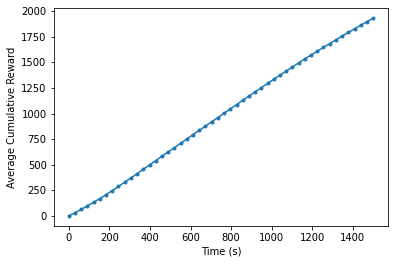

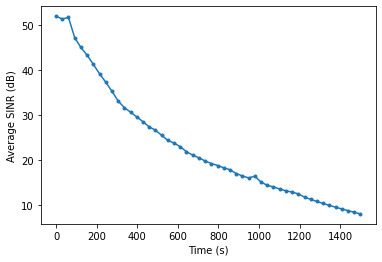

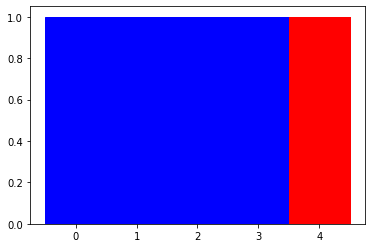

In [18]:
plt.figure()
plt.plot(time, current_reward, '.-')
plt.xlabel('Time (s)')
plt.ylabel('Average Cumulative Reward')

plt.figure()
plt.plot(time, current_sinr, '.-')
plt.xlabel('Time (s)')
plt.ylabel('Average SINR (dB)')
plt.savefig('SINR')
animate_spectrum(tx_history, interference_history)